In [1]:
import hydra
import matplotlib.pyplot as plt
import torch

from autoencoders.constants import Constants
from autoencoders.modules import WhiteNoise

constants = Constants()

In [2]:
def plot_image(a):
    with plt.style.context("grayscale"):
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
        ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
        ax.imshow(a)

In [3]:
def plot_images(images):
    n = len(images)
    with plt.style.context("grayscale"):
        fig, ax = plt.subplots(1, n, figsize=(2*n, 2*n))
        if n == 1:
            ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
            ax.imshow(images[0])
        else:
            for i in range(n):
                ax[i].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
            for i in range(n):
                ax[i].imshow(images[i])
        plt.show()

In [4]:
def get_model(model, config):
    module = hydra.utils.instantiate(config.models[model].module)
    ckpt_path = constants.OUTPUTS.joinpath(config.models[model].ckpt_path)
    return module.load_from_checkpoint(ckpt_path, map_location=torch.device("cpu"))

In [5]:
def predict(model, x):
    model.eval()
    with torch.no_grad():
        return model(x)

In [6]:
hydra.initialize(config_path='../autoencoders/conf', version_base="1.3")
cfg = hydra.compose(config_name='config')
model_cfg = hydra.compose(config_name='comps')

/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [7]:
dl = hydra.utils.instantiate(cfg.data.train)
batch = next(iter(dl))
images = batch[0]

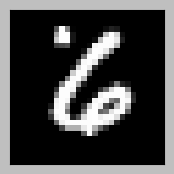

In [8]:
plot_image(images[17].squeeze())
plt.show()

In [9]:
x = images[17]

# Autoencoder

In [10]:
mod = get_model('ae', model_cfg)
xx = predict(mod, x)

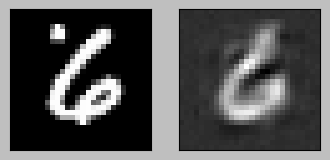

In [11]:
plot_images([x.squeeze(), xx.squeeze()])

# Denoising Autoencoder

In [12]:
noise = WhiteNoise(factor=.2)
mod = get_model('dae', model_cfg)
xx = predict(mod, x)

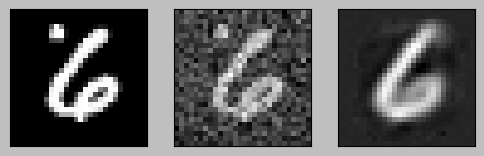

In [13]:
plot_images([x.squeeze(), noise(x.squeeze()), xx.squeeze()])

# Deep Autoencoder

In [14]:
mod = get_model('deep-ae', model_cfg)
xx = predict(mod, x.unsqueeze(0))

/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


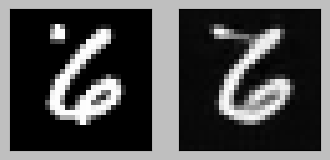

In [15]:
plot_images([x.squeeze(), xx.squeeze()])

# Deep Denoising Autoencoder

In [16]:
noise = WhiteNoise(factor=.2)
mod = get_model('deep-dae', model_cfg)
xx = predict(mod, x.unsqueeze(0))

/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


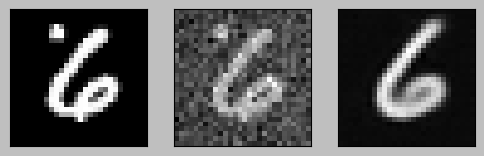

In [17]:
plot_images([x.squeeze(), noise(x.squeeze()), xx.squeeze()])

# Variational Autoencoder

In [18]:
mod = get_model('vae', model_cfg)
xx = predict(mod, x.unsqueeze(0))

/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


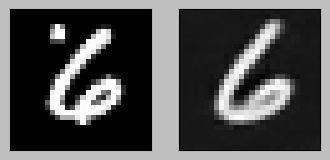

In [19]:
plot_images([x.squeeze(), xx[0].squeeze()])

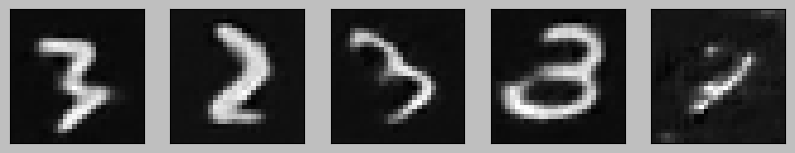

In [20]:
mod.eval()
with torch.no_grad():
    samples = [mod.decoder(xx[1].sample()).squeeze() for _ in range(5)]
    plot_images(samples)

# Siamese Denoising Autoencoder

In [21]:
sidae_cfg = hydra.compose(config_name='config', overrides=['model=sidae', 'data=sidae'])

/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [22]:
dl = hydra.utils.instantiate(sidae_cfg.data.train)
batch = next(iter(dl))
aug_1, aug_2, noisy, orig = batch

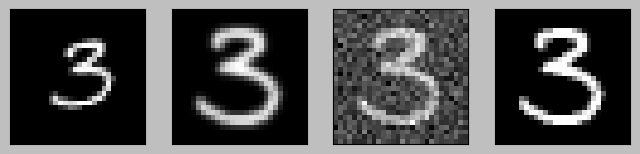

In [49]:
i = 19
plot_images(
    [aug_1[i].squeeze(), aug_2[i].squeeze(), noisy[i].squeeze(), orig[i].squeeze()]
)

In [53]:
model_cfg = hydra.compose(config_name='comps')
mod = get_model('sidae', model_cfg)

/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.
  rank_zero_wa

In [54]:
mod.eval()
with torch.no_grad():
    xx = mod.decoder(mod.encoder(orig[i].unsqueeze(0)))

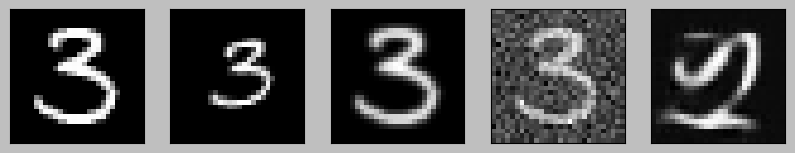

In [55]:
plot_images(
    [orig[i].squeeze(), aug_1[i].squeeze(), aug_2[i].squeeze(), noisy[i].squeeze(), xx.squeeze()]
)

In [47]:
sidae_cfg = hydra.compose(config_name='config', overrides=['model=sidae', 'data=sidae'])

/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [50]:
model_cfg = hydra.compose(config_name='comps')
mod = get_model('sidae', model_cfg)

/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/autoencoders/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.
  rank_zero_wa

In [51]:
mod.eval()
with torch.no_grad():
    xx = mod.decoder(mod.encoder(orig[i].unsqueeze(0)))

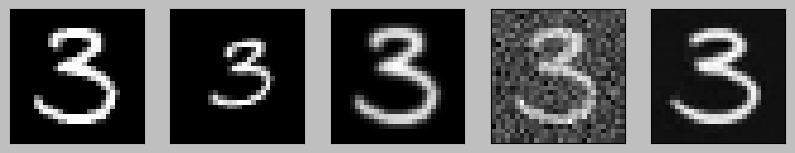

In [52]:
plot_images(
    [orig[i].squeeze(), aug_1[i].squeeze(), aug_2[i].squeeze(), noisy[i].squeeze(), xx.squeeze()]
)

------------

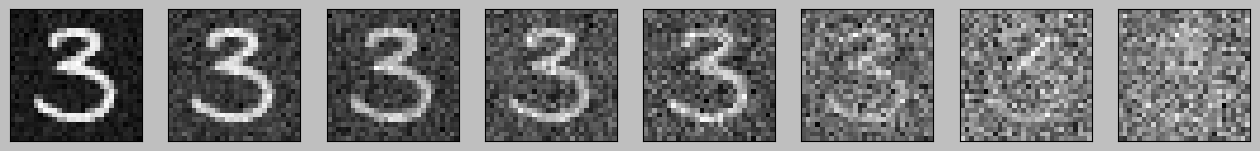

In [57]:
plot_images(
    [WhiteNoise(factor=f)(orig[i]).squeeze() for f in [.05, .1, .15, .2, .25, .5, .75, 1.]]
)

In [69]:
class ImageMask(nn.Module):
    def __init__(self, p=0.5, loc=0, scale=1, factor=1):
        super().__init__()
        self.p = p

    def forward(self, x):
        p_dist = torch.distributions.Bernoulli(1-self.p)
        mask = p_dist.sample(sample_shape=x.shape).to(x.device)
        return x * mask

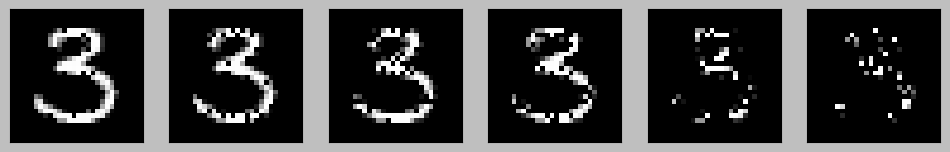

In [88]:
plot_images(
    [ImageMask(p=p)(orig[i]).squeeze() for p in [.1, .2, .3, .4, .5, .75]]
)

In [73]:
import torchvision.transforms as T

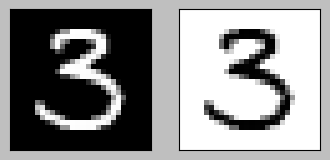

In [80]:
plot_images(
    [T.RandomInvert(p=p)(orig[i]).squeeze() for p in [.0, 1.]]
)

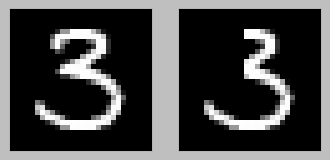

In [105]:
plot_images(
    [T.RandomErasing(p=p, scale=(.05, .15))(orig[i]).squeeze() for p in [.0, 1.]]
)

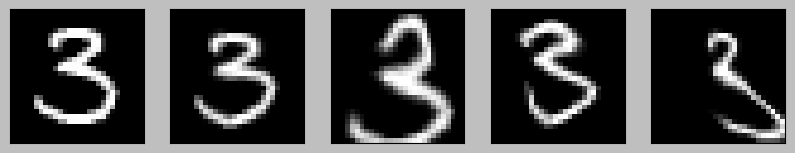

In [111]:
plot_images(
    [T.ElasticTransform(alpha=a)(orig[i]).squeeze() for a in [0., 50., 100., 150., 200.]]
)

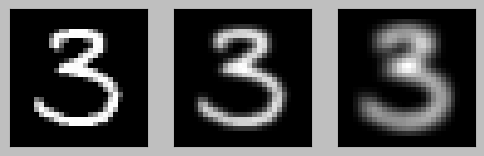

In [127]:
plot_images(
    [T.GaussianBlur(kernel_size=x)(orig[i]).squeeze() for x in [1, 3, 5]]
)

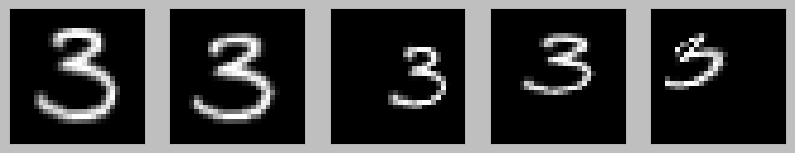

In [211]:
plot_images(
    [T.RandomPerspective(distortion_scale=x, p=1.)(orig[i]).squeeze() for x in [.1, .25, .5, .75, 1.]]
)

In [151]:
class RandWhiteNoise(nn.Module):
    def __init__(self, loc=0, scale=1, factor=(0, 1)):
        super().__init__()
        self.loc = loc
        self.scale = scale
        self.factor = factor

    def forward(self, x):
        dist_f = torch.distributions.Uniform(*self.factor)
        factor = dist_f.sample().to(x.device)
        dist = torch.distributions.Normal(self.loc, self.scale)
        noise = dist.sample(sample_shape=x.shape).to(x.device)
        return x + (noise * factor)

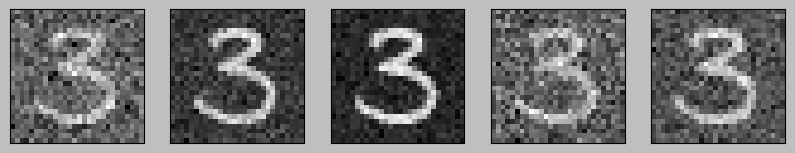

In [161]:
plot_images(
    [RandWhiteNoise(factor=(0.05, 0.75))(orig[i]).squeeze() for _ in range(5)]
)

In [194]:
applier = T.RandomChoice(
    transforms=[
        T.GaussianBlur(kernel_size=5),
        T.RandomErasing(p=1., scale=(.05, .15)),
        ImageMask(p=.4),
        T.ElasticTransform(alpha=100.),
        RandWhiteNoise(factor=(0.15, 0.75)),
        T.RandomPerspective()
    ]
)

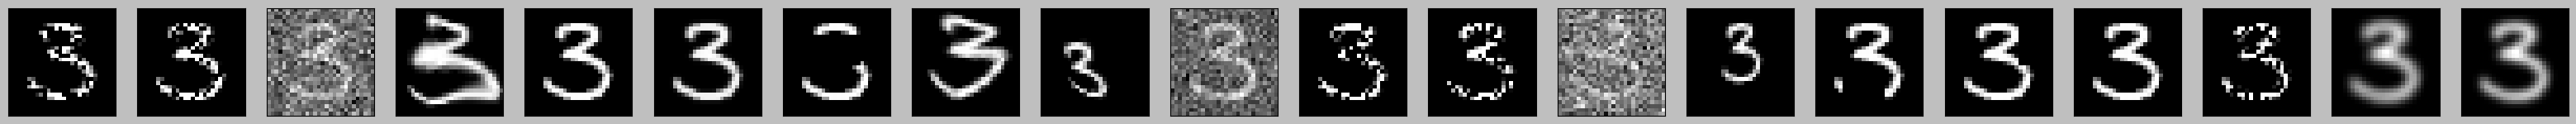

In [196]:
plot_images(
    [applier(orig[i]).squeeze() for _ in range(20)]
)